# CS677 Machine Learning Final Project
## Insurance Cost Per Family

by Kelsey Woods and Aayushi Verma

We are using a dataset titled Medical Cost Personal Dataset by Kaggle https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download. It lists the cost per family and its possibly associated factors.

In [570]:
# importing packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

### Preparation & EDA

We start by performing Exploratory Data Analysis and cleaning on this dataset to prepare for the machine learning process.

In [571]:
# reading data
df = pd.read_csv('/content/insurance.csv')

In [572]:
# checking data structure
df.head(15)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [573]:
# checking data content
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [574]:
columns_to_drop = ['sex', 'smoker', 'region', 'children', 'age']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

print(df)

         bmi      charges
0     27.900  16884.92400
1     33.770   1725.55230
2     33.000   4449.46200
3     22.705  21984.47061
4     28.880   3866.85520
...      ...          ...
1333  30.970  10600.54830
1334  31.920   2205.98080
1335  36.850   1629.83350
1336  25.800   2007.94500
1337  29.070  29141.36030

[1338 rows x 2 columns]


In [575]:
df.fillna(df.mean())

,bmi,charges
0,27.900,16884.92400
1,33.770,1725.55230
2,33.000,4449.46200
3,22.705,21984.47061
4,28.880,3866.85520
...,...,...
1333,30.970,10600.54830
1334,31.920,2205.98080
1335,36.850,1629.83350
1336,25.800,2007.94500


In [576]:
# Drop duplicates based on all columns
df_no_duplicates = df.drop_duplicates()

# Drop duplicates based on specific columns
columns_to_check = ['bmi', 'charges']  # Replace with the column names you want to consider
df_no_duplicates_specific = df.drop_duplicates(subset=columns_to_check)

# Print the shape of the resulting DataFrames
print("Original DataFrame shape:", df.shape)
print("DataFrame shape after dropping all duplicates:", df_no_duplicates.shape)
print("DataFrame shape after dropping duplicates based on specific columns:", df_no_duplicates_specific.shape)


Original DataFrame shape: (1338, 2)
DataFrame shape after dropping all duplicates: (1337, 2)
DataFrame shape after dropping duplicates based on specific columns: (1337, 2)


<Axes: >

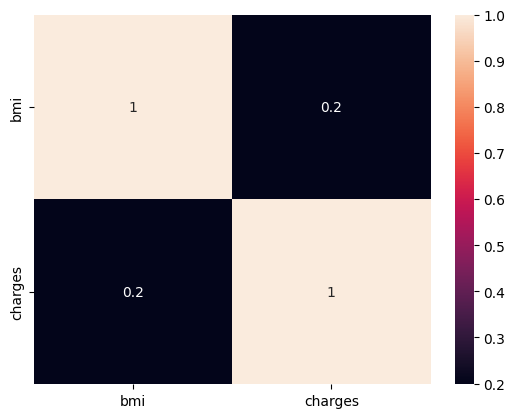

In [577]:
# performing label encoding of data and displaying correlation matrix
df_e = pd.get_dummies(df)
corrMatrix_e = df_e.corr()
sns.heatmap(corrMatrix_e, annot=True)

In [578]:
# checking data structure again
df.head()

,bmi,charges
0,27.900,16884.92400
1,33.770,1725.55230
2,33.000,4449.46200
3,22.705,21984.47061
4,28.880,3866.85520


In [579]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bmi      1338 non-null   float64
 1   charges  1338 non-null   float64
dtypes: float64(2)
memory usage: 21.0 KB


Text(0.5, 1.0, 'Histogram of Distinct Charged Amounts in Dataset')

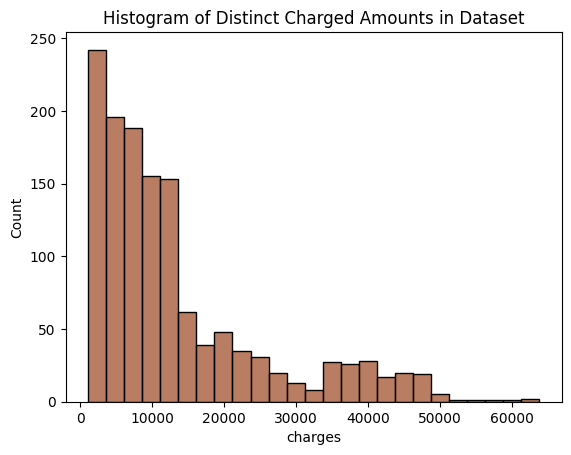

In [580]:
# EDA for one column
sns.histplot(df['charges'], bins=25, color='sienna')
plt.title('Histogram of Distinct Charged Amounts in Dataset')

Text(0.5, 1.0, 'Histogram of Distinct Number of Children in Dataset')

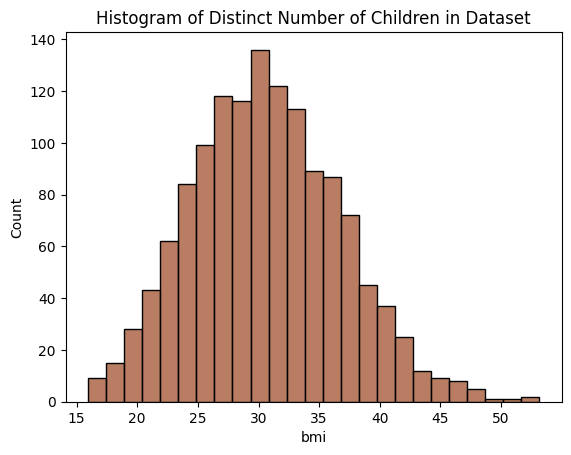

In [581]:
# EDA for another column
sns.histplot(df['bmi'], bins=25, color='sienna')
plt.title('Histogram of Distinct Number of Children in Dataset')

Text(0.5, 1.0, 'Children vs Charges for Insurance')

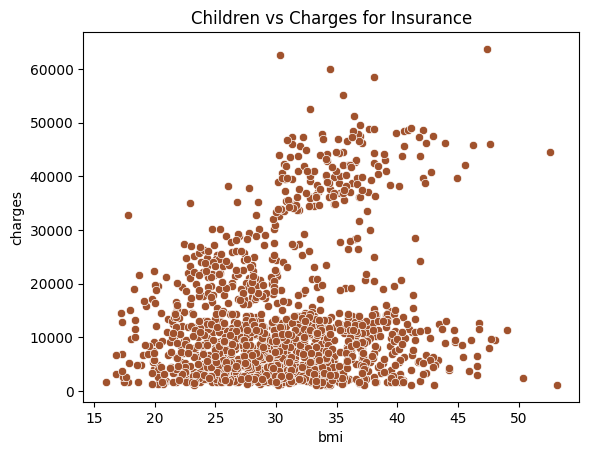

In [582]:
# scatterplot time!
sns.scatterplot(x='bmi', y='charges', data=df,
                color='sienna')
plt.title('Children vs Charges for Insurance')

### Machine Learning

Now we perform machine learning on our cleaned dataset.

In [583]:
X = df.drop('charges', axis=1)
y = df['charges']

In [584]:
print(X)

         bmi
0     27.900
1     33.770
2     33.000
3     22.705
4     28.880
...      ...
1333  30.970
1334  31.920
1335  36.850
1336  25.800
1337  29.070

[1338 rows x 1 columns]


In [585]:
print(y)

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64


In [586]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bmi      1338 non-null   float64
 1   charges  1338 non-null   float64
dtypes: float64(2)
memory usage: 21.0 KB


In [587]:
print("Shape of df:", df.shape)

Shape of df: (1338, 2)


In [588]:
df['bmi'] = df['bmi'].astype(int)

In [589]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 1. Decision Tree Classifier

In [590]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=90)

# Train the model
dt_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_regressor.predict(X_test)

# Evaluate the model using Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 253441486.65462786
R-squared: -0.6324866826242477


In [591]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=50)

# Perform cross-validation for Decision Tree Regressor
cv_scores_dt = cross_val_score(dt_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_dt = (-cv_scores_dt)**0.5

print("Cross-Validation RMSE scores for Decision Tree Regressor:", cv_rmse_dt)
print("Mean CV RMSE for Decision Tree Regressor:", cv_rmse_dt.mean())

# Train the Decision Tree Regressor model
dt_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_regressor.predict(X_test)

# Evaluate the Decision Tree Regressor model using Mean Squared Error and R-squared
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Regressor Mean Squared Error:", mse_dt)
print("Decision Tree Regressor R-squared:", r2_dt)

# Create a Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=42)

# Perform cross-validation for Gradient Boosting Regressor
cv_scores_gb = cross_val_score(gb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_gb = (-cv_scores_gb)**0.5

print("Cross-Validation RMSE scores for Gradient Boosting Regressor:", cv_rmse_gb)
print("Mean CV RMSE for Gradient Boosting Regressor:", cv_rmse_gb.mean())

Cross-Validation RMSE scores for Decision Tree Regressor: [16796.9475412  15686.35545122 14168.88258353 14526.0908028
 14728.09313643]
Mean CV RMSE for Decision Tree Regressor: 15181.273903036315
Decision Tree Regressor Mean Squared Error: 253441486.65462786
Decision Tree Regressor R-squared: -0.6324866826242477
Cross-Validation RMSE scores for Gradient Boosting Regressor: [13416.42438997 13171.09320599 11844.061232   11750.18840236
 12461.0344567 ]
Mean CV RMSE for Gradient Boosting Regressor: 12528.560337403705


### Linear Regression

In [592]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create a Linear Regression model
linear_reg_model = LinearRegression()

# Train the model
linear_reg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_reg_model.predict(X_test)

# Evaluate the model using Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 149085057.03839505
R-squared: 0.03970193117941878


In [593]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Perform cross-validation for Linear Regression
cv_scores_lr = cross_val_score(linear_reg_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_lr = (-cv_scores_lr)**0.5

print("Cross-Validation RMSE scores for Linear Regression:", cv_rmse_lr)
print("Mean CV RMSE for Linear Regression:", cv_rmse_lr.mean())

# Train the Linear Regression model
linear_reg_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = linear_reg_model.predict(X_test)

# Evaluate the Linear Regression model using Mean Squared Error and R-squared
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Mean Squared Error:", mse_lr)
print("Linear Regression R-squared:", r2_lr)


Cross-Validation RMSE scores for Linear Regression: [11654.24105352 12421.78159765 11357.22976307 11551.56920973
 11982.93376558]
Mean CV RMSE for Linear Regression: 11793.551077908991
Linear Regression Mean Squared Error: 149085057.03839505
Linear Regression R-squared: 0.03970193117941878


In [595]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

# Define parameter grid for Ridge and Lasso
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
param_grid_lasso = {'alpha': [0.1, 1.0, 10.0]}

# Create Ridge and Lasso models
ridge_regressor = Ridge()
lasso_regressor = Lasso()

# Initialize GridSearchCV for Ridge and Lasso
grid_search_ridge = GridSearchCV(ridge_regressor, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso = GridSearchCV(lasso_regressor, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV for Ridge and Lasso
grid_search_ridge.fit(X_train, y_train)
grid_search_lasso.fit(X_train, y_train)

# Get the best parameters and models for Ridge and Lasso
best_params_ridge = grid_search_ridge.best_params_
best_params_lasso = grid_search_lasso.best_params_
best_ridge_model = grid_search_ridge.best_estimator_
best_lasso_model = grid_search_lasso.best_estimator_

# Evaluate the best Ridge model
y_pred_best_ridge = best_ridge_model.predict(X_test)
best_mse_ridge = mean_squared_error(y_test, y_pred_best_ridge)

# Evaluate the best Lasso model
y_pred_best_lasso = best_lasso_model.predict(X_test)
best_mse_lasso = mean_squared_error(y_test, y_pred_best_lasso)

print("Best Ridge Parameters:", best_params_ridge)
print("Best Ridge Model MSE:", best_mse_ridge)

print("Best Lasso Parameters:", best_params_lasso)
print("Best Lasso Model MSE:", best_mse_lasso)


Best Ridge Parameters: {'alpha': 10.0}
Best Ridge Model MSE: 149085099.00473535
Best Lasso Parameters: {'alpha': 10.0}
Best Lasso Model MSE: 149085173.38900563


### Support Vector Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Create a Support Vector Regression model
svr_model = SVR()

# Train the model
svr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svr_model.predict(X_test)

# Evaluate the model using Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Perform cross-validation for Support Vector Regression
cv_scores_svr = cross_val_score(svr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_svr = (-cv_scores_svr)**0.5

print("Cross-Validation RMSE scores for Support Vector Regression:", cv_rmse_svr)
print("Mean CV RMSE for Support Vector Regression:", cv_rmse_svr.mean())

# Train the Support Vector Regression model
svr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svr = svr_model.predict(X_test)

# Evaluate the Support Vector Regression model using Mean Squared Error and R-squared
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Support Vector Regression Mean Squared Error:", mse_svr)
print("Support Vector Regression R-squared:", r2_svr)

In [596]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Define parameter grid for SVR
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1.0, 10.0],
    'gamma': ['scale', 'auto']
}

# Create SVR model
svr_regressor = SVR()

# Initialize GridSearchCV for SVR
grid_search = GridSearchCV(svr_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("Best Model MSE:", best_mse)


Best Parameters: {'C': 10.0, 'gamma': 'scale', 'kernel': 'linear'}
Best Model MSE: 163380966.5017033


### Lasso Regression

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Create a Lasso Regression model
lasso_model = Lasso(alpha=1.0)  # You can adjust the alpha value

# Train the model
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lasso_model.predict(X_test)

# Evaluate the model using Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Perform cross-validation for Lasso Regression
cv_scores_lasso = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_lasso = (-cv_scores_lasso)**0.5

print("Cross-Validation RMSE scores for Lasso Regression:", cv_rmse_lasso)
print("Mean CV RMSE for Lasso Regression:", cv_rmse_lasso.mean())

# Train the Lasso Regression model
lasso_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lasso = lasso_model.predict(X_test)

# Evaluate the Lasso Regression model using Mean Squared Error and R-squared
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression Mean Squared Error:", mse_lasso)
print("Lasso Regression R-squared:", r2_lasso)

### Random Forest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust n_estimators and other parameters

# Perform cross-validation for Random Forest Regressor
cv_scores_rf = cross_val_score(rf_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse_rf = (-cv_scores_rf)**0.5

print("Cross-Validation RMSE scores for Random Forest Regressor:", cv_rmse_rf)
print("Mean CV RMSE for Random Forest Regressor:", cv_rmse_rf.mean())

# Train the Random Forest Regressor model
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_regressor.predict(X_test)

# Evaluate the Random Forest Regressor model using Mean Squared Error and R-squared
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Mean Squared Error:", mse_rf)
print("Random Forest Regressor R-squared:", r2_rf)

#Gradient Boosting

In [ ]:
# Train the Gradient Boosting Regressor model
gb_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_regressor.predict(X_test)

# Evaluate the Gradient Boosting Regressor model using Mean Squared Error and R-squared
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting Regressor Mean Squared Error:", mse_gb)
print("Gradient Boosting Regressor R-squared:", r2_gb)

#Overfitting and Underfitting Check

##Linear Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Create Linear Regression models with different complexities
model_underfit = LinearRegression()
model_overfit = LinearRegression()
model_fitting = LinearRegression()

# Underfitting Model
model_underfit.fit(X_train, y_train)

# Overfitting Model
model_overfit.fit(X_train, y_train)
X_poly = np.column_stack((X_train, X_train**2))
model_overfit.fit(X_poly, y_train)

# Fitting Model
model_fitting.fit(X_train, y_train)

# Predict on test set
y_pred_underfit = model_underfit.predict(X_test)
y_pred_overfit = model_overfit.predict(np.column_stack((X_test, X_test**2)))
y_pred_fitting = model_fitting.predict(X_test)

# Calculate Mean Squared Error for each model
mse_underfit = mean_squared_error(y_test, y_pred_underfit)
mse_overfit = mean_squared_error(y_test, y_pred_overfit)
mse_fitting = mean_squared_error(y_test, y_pred_fitting)

print("MSE Underfit:", mse_underfit)
print("MSE Overfit:", mse_overfit)
print("MSE Fitting:", mse_fitting)

# Plot the predictions and true values
plt.scatter(X_test, y_test, label='True Values')
plt.scatter(X_test, y_pred_underfit, label='Underfit Predictions')
plt.scatter(X_test, y_pred_fitting, label='Fitting Predictions')
plt.scatter(X_test, y_pred_overfit, label='Overfit Predictions')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Overfitting and Underfitting Example')
plt.show()

##Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Create Random Forest Regressors with different complexities
model_underfit = RandomForestRegressor(n_estimators=10, random_state=42)
model_fitting = RandomForestRegressor(n_estimators=100, random_state=42)
model_overfit = RandomForestRegressor(n_estimators=200, random_state=42)

# Train the models
model_underfit.fit(X_train, y_train)
model_fitting.fit(X_train, y_train)
model_overfit.fit(X_train, y_train)

# Predict on test set
y_pred_underfit = model_underfit.predict(X_test)
y_pred_fitting = model_fitting.predict(X_test)
y_pred_overfit = model_overfit.predict(X_test)

# Calculate Mean Squared Error for each model
mse_underfit = mean_squared_error(y_test, y_pred_underfit)
mse_fitting = mean_squared_error(y_test, y_pred_fitting)
mse_overfit = mean_squared_error(y_test, y_pred_overfit)

print("MSE Underfit:", mse_underfit)
print("MSE Fitting:", mse_fitting)
print("MSE Overfit:", mse_overfit)

# Plot the predictions and true values
plt.scatter(X_test, y_test, label='True Values')
plt.scatter(X_test, y_pred_underfit, label='Underfit Predictions')
plt.scatter(X_test, y_pred_fitting, label='Fitting Predictions')
plt.scatter(X_test, y_pred_overfit, label='Overfit Predictions')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Random Forest Overfitting and Underfitting Example')
plt.show()


##SVR

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Create SVR models with different complexities
model_underfit = SVR(kernel='linear', C=1)
model_fitting = SVR(kernel='linear', C=100)
model_overfit = SVR(kernel='rbf', C=100, gamma=0.1)

# Train the models
model_underfit.fit(X_train, y_train)
model_fitting.fit(X_train, y_train)
model_overfit.fit(X_train, y_train)

# Predict on test set
y_pred_underfit = model_underfit.predict(X_test)
y_pred_fitting = model_fitting.predict(X_test)
y_pred_overfit = model_overfit.predict(X_test)

# Calculate Mean Squared Error for each model
mse_underfit = mean_squared_error(y_test, y_pred_underfit)
mse_fitting = mean_squared_error(y_test, y_pred_fitting)
mse_overfit = mean_squared_error(y_test, y_pred_overfit)

print("MSE Underfit:", mse_underfit)
print("MSE Fitting:", mse_fitting)
print("MSE Overfit:", mse_overfit)

# Plot the predictions and true values
plt.scatter(X_test, y_test, label='True Values')
plt.scatter(X_test, y_pred_underfit, label='Underfit Predictions')
plt.scatter(X_test, y_pred_fitting, label='Fitting Predictions')
plt.scatter(X_test, y_pred_overfit, label='Overfit Predictions')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVR Overfitting and Underfitting Example')
plt.show()

##Decision Tree Classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Create Decision Tree Regressors with different depths
model_underfit = DecisionTreeRegressor(max_depth=1, random_state=42)
model_fitting = DecisionTreeRegressor(max_depth=5, random_state=42)
model_overfit = DecisionTreeRegressor(max_depth=None, random_state=42)

# Train the models
model_underfit.fit(X_train, y_train)
model_fitting.fit(X_train, y_train)
model_overfit.fit(X_train, y_train)

# Predict on test set
y_pred_underfit = model_underfit.predict(X_test)
y_pred_fitting = model_fitting.predict(X_test)
y_pred_overfit = model_overfit.predict(X_test)

# Calculate Mean Squared Error for each model
mse_underfit = mean_squared_error(y_test, y_pred_underfit)
mse_fitting = mean_squared_error(y_test, y_pred_fitting)
mse_overfit = mean_squared_error(y_test, y_pred_overfit)

print("MSE Underfit:", mse_underfit)
print("MSE Fitting:", mse_fitting)
print("MSE Overfit:", mse_overfit)

# Plot the predictions and true values
plt.scatter(X_test, y_test, label='True Values')
plt.scatter(X_test, y_pred_underfit, label='Underfit Predictions')
plt.scatter(X_test, y_pred_fitting, label='Fitting Predictions')
plt.scatter(X_test, y_pred_overfit, label='Overfit Predictions')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Decision Tree Regressor Overfitting and Underfitting Example')
plt.show()

##Lasso

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Create Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Create Lasso Regression model
lasso_model = Lasso(alpha=0.01)  # You can adjust the regularization strength (alpha)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# Calculate Mean Squared Error for each model
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("Linear Regression Mean Squared Error:", mse_linear)
print("Lasso Regression Mean Squared Error:", mse_lasso)

# Plot the true values and predictions
plt.scatter(y_test, y_pred_linear, label='Linear Regression')
plt.scatter(y_test, y_pred_lasso, label='Lasso Regression')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear vs Lasso Regression')
plt.legend()
plt.show()


## Results

In [ ]:
# comparing all metrics for this stage of analysis
fig, ax = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(30, 10), dpi=300)
x_labels = results['ml_algorithm']
indices = np.arange(len(x_labels))
width = 0.3

#row=0, col=0
ax[0,0].bar(indices,results['mae'],color="lightcoral",alpha=1,label="MAE")
ax[0,0].grid(True,alpha=0.5)
# ax[0,0].set_ylim(0,1)
ax[0,0].set_xlabel("algorithm")
ax[0,0].set_ylabel("MAE")
ax[0,0].set_title("MAE Comparison")
ax[0,0].legend(loc='lower right')
ax[0,0].set_xticks(indices, x_labels, rotation=45)

#row=0, col=1
ax[0,1].bar(indices,results['mse'],color="gold",alpha=1,label="MSE")
ax[0,1].grid(True,alpha=0.5)
# ax[0,1].set_ylim(0,1)
ax[0,1].set_xlabel("algorithm")
ax[0,1].set_ylabel("MSE")
ax[0,1].set_title("MSE Comparison")
ax[0,1].legend(loc='lower right')
ax[0,1].set_xticks(indices, x_labels, rotation=45)

#row=0, col=2
ax[0,2].bar(indices,results['rmse'],color="lightgreen",alpha=1,label="RMSE")
ax[0,2].grid(True,alpha=0.5)
# ax[0,2].set_ylim(0,1)
ax[0,2].set_xlabel("algorithm")
ax[0,2].set_ylabel("RMSE")
ax[0,2].set_title("RMSE Comparison")
ax[0,2].legend(loc='lower right')
ax[0,2].set_xticks(indices, x_labels, rotation=45)

#row=1, col=0
ax[1,0].bar(indices,results['r2'],color="lightskyblue",alpha=1,label="R2")
ax[1,0].grid(True,alpha=0.5)
# ax[1,0].set_ylim(0,1)
ax[1,0].set_xlabel("algorithm")
ax[1,0].set_ylabel("R2")
ax[1,0].set_title("R2 Comparison")
ax[1,0].legend(loc='lower right')
ax[1,0].set_xticks(indices, x_labels, rotation=45)

#row=1, col=1
ax[1,1].bar(indices,results['adjusted_r2'],color="mediumpurple",alpha=1,label="Adjusted R2")
ax[1,1].grid(True,alpha=0.5)
# ax[1,1].set_ylim(0,1)
ax[1,1].set_xlabel("algorithm")
ax[1,1].set_ylabel("Adjusted R2")
ax[1,1].set_title("Adjusted R2 Comparison")
ax[1,1].legend(loc='lower right')
ax[1,1].set_xticks(indices, x_labels, rotation=45)

#row=1, col=2
ax[1,2].bar(indices,results['cross_val'],color="darkgrey",alpha=1,label="Cross-Validation Score")
ax[1,2].grid(True,alpha=0.5)
# ax[1,2].set_ylim(0,1)
ax[1,2].set_xlabel("algorithm")
ax[1,2].set_ylabel("Mean Cross-Validation Score")
ax[1,2].set_title("Mean Cross-Validation Score Comparison")
ax[1,2].legend(loc='lower right')
ax[1,2].set_xticks(indices, x_labels, rotation=45)

## Discussion and Conclusion

MAE (Mean Absolute Error) measures mean absolute difference between actual and predicted values. The lower the MAE value, the more accurate the model is. In our case, we see that the Support Vector Regression model has the lowest MAE, which taking into account our target variable, Caffeine (mg), indicates that on average, the model predicts the value of caffeine amount differs from the actual caffeiene amount by 34 mg. The next well-performing models are Random Forest and Lasso Regression, with MAE values of 44 and 59 mg respectively. The worst-performing models are Linear Regression and Decision Tree, with MAE values of 85 and 86 mg of caffeine, which is too big a difference.

MSE (Mean Squared Error) measures mean squared difference between actual and prediced values, and penalizes the error more and to see how the outliers are affecting the predictions. The lower the MSE value, the more accurate the model is. The RMSE is just the squared root of the MSE value. In our case, we find that the Support Vector Regression model again has the lowest RMSE of 52 mg, followed by Random Forest and Lasso Regression, with RMSE values of 56 and 72 mg respectively. Again, we find the worst-performing models are Linear Regression and Decision Tree, with RMSE values of 90 and 104 mg respectively.

R2 measures how the independent variable(s) (X) affect the dependent/target variable, Y. R2 value is always betweeen 0 and 1, where 0 indicates the model does not explain any variablity in the target variable, and 1 indicates it explains full variability in Y. We find that the Decision Tree model has a negative R2 value, which is not possible and indicates either there is something wrong with the model, or it is not a good fit for our problem. We will disregard it. The other 4 models have R2 values less than 0.5, indicating the model explains some variability in the target variable to a lesser extent.

Adjusted R2 takes into account the number of features in the model and its degrees of freedom. Its value only increases if the new term improves the accuracy. We see that the adjusted R2 value are proportionate to the R2 values and follow that same pattern, which indicates the model is not too complex.

